In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import minimize


def zscore(series):
    return (series - series.mean()) / series.std()


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid(x, k=1, x0=0):
    return 1 / (1 + np.exp(-k * (x - x0)))


def adjusted_sigmoid(x, f_min=0.01, f_max=0.1, k=1, x0=0):
    return f_min + (f_max - f_min) * sigmoid(x, k=k, x0=x0)


def global_sigmoid(x, f_min, f_max, k=1, x0=0):
    if x > 0:
        return adjusted_sigmoid(x, f_min, f_max, k, x0)
    else:
        return adjusted_sigmoid(-x, f_min, f_max, k, x0)
    
    
def calculate_markout(d, v, f, p):
    m = d * v * (f - p)
    return m


def buy_fee(x,  f_min, f_max, w_buy):
    return min(f_max, f_min + w_buy * max(0, x))


def sell_fee(x,  f_min, f_max, w_sell):
    return min(f_max, f_min - w_sell * min(0, x))


def cost_function_buy(k, delta_ps, f_min, f_max, w_buy, x0):
    sigmoid_fees = np.array([adjusted_sigmoid(x, f_min, f_max, k, x0) for x in delta_ps])
    linear_fees = np.array([buy_fee(x,  f_min, f_max, w_buy) for x in delta_ps])
    return np.sum((sigmoid_fees - linear_fees) ** 2)


def cost_function_sell(k, delta_ps, f_min, f_max, w_sell, x0):
    sigmoid_fees = np.array([adjusted_sigmoid(-x, f_min, f_max, k, x0) for x in delta_ps])
    linear_fees = np.array([sell_fee(x,  f_min, f_max, w_sell) for x in delta_ps])
    return np.sum((sigmoid_fees - linear_fees) ** 2)


data_p1 = pd.read_pickle('data/Merged_CEX_DEX_v2_p1.pkl')
data_p2 = pd.read_pickle('data/Merged_CEX_DEX_v2_p2.pkl')
data_p3 = pd.read_pickle('data/Merged_CEX_DEX_v2_p3.pkl')

data_p1['time'] = pd.to_datetime(data_p1['time'])
data_p2['time'] = pd.to_datetime(data_p2['time'])
data_p3['time'] = pd.to_datetime(data_p3['time'])

data = pd.concat([data_p1, data_p2, data_p3])
data = data.rename(columns={'LVR_clean': 'price_diff', 'LVR': 'arb_pnl' })
data = data.sort_values('time')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
data['impermanent_loss'] = (2 * np.sqrt(data['price_dex'].shift(1) / data['price_dex']) / (1 + data['price_dex'].shift(1) / data['price_dex']) - 1).fillna(0)
data['LVR_nbtoken']= data['arb_pnl']/data['price_dex']
data['avg_gas']    = data['gasUsed'] * data['gasPrice_eth'].rolling(100).mean() * data['price_dex']
data['arb_fee']    = (np.abs(2*data['arb_pnl']) - (data['tcost_usd'] - data['avg_gas']))*100 / data['amountUSD']
data['LVR_zscore'] = zscore(data['arb_pnl'])
data['std']             = data['price_dex'].rolling(100).std()
data['mean_rol_amount'] = data['amountUSD'].rolling(10).mean()
data['rol_amountUSD']   = data['amountUSD'].rolling(100).sum()

# can be seen as looking ahead but in a DEX we can compute it aheat with the liquidity and the amount
data['price_impact']    = (data['price_dex'].pct_change(1).shift(-1)*100).abs()

data['time_diff']          = data['time'].diff().dt.total_seconds().fillna(0)

data['rol_1min_span']      = data['time_diff'].rolling(window=60, min_periods=1).sum() 
data['rol_1m_trade_count'] = data['time'].rolling(window=60, min_periods=1).count()
data['lambda_1min']        = data['rol_1m_trade_count'] / data['rol_1min_span']
data['lambda_1min'].replace([float('inf'), float('-inf'), pd.NA], 0, inplace=True)

data['rol_5min_span']      = data['time_diff'].rolling(window=60*5, min_periods=1).sum() 
data['rol_5m_trade_count'] = data['time'].rolling(window=60*5, min_periods=1).count()
data['lambda_5min']        = data['rol_5m_trade_count'] / data['rol_5min_span']
data['lambda_5min'].replace([float('inf'), float('-inf'), pd.NA], 0, inplace=True)
data = data.drop(columns=['time_diff'])

data['target_fee'] = -np.tanh(np.sign(data['amount1']) * data['arb_fee']/100)

data = data.dropna()

features = ['LVR_nbtoken', 'price_diff', 'arb_pnl', 'std', 'mean_rol_amount', 'avg_gas', 'price_impact', 'rol_amountUSD',
            'lambda_1min', 'rol_1min_span', 'rol_1m_trade_count', 
            'lambda_5min', 'rol_5min_span', 'rol_5m_trade_count', 'amountUSD']
target = 'tcost_usd'

lower_bound = data[features].quantile(0.10)
upper_bound = data[features].quantile(0.90)
filtered_indices = data[features].apply(lambda x: x.between(lower_bound[x.name], upper_bound[x.name])).all(axis=1)
data_filtered = data.loc[filtered_indices].copy()

# max and min fee in %
f_min = 0.01
f_max = 0.1

params = {}
for f in features:
    params[f] = {'lower_quantile': 0.1, 'upper_quantile': 0.9}
    
data

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,mean_rol_amount,rol_amountUSD,price_impact,rol_1min_span,rol_1m_trade_count,lambda_1min,rol_5min_span,rol_5m_trade_count,lambda_5min,target_fee
99,6318.571324,-2.753365,6310.474821,0xf3e01e963796ad8ed86fc7dbce195eaa3aaf4e4a,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,414642,1.216669e+10,1.216669e-08,...,31679.388299,3.274054e+06,0.009999,1032.0,60.0,0.058140,1404.0,100.0,0.071225,0.002317
100,-160.477545,0.070000,160.352835,0xea08db5fb88d6f1f4978400ec2c57d9a29e85e99,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xef5edb29b4eb20501de89718daa7d1ad108efb66,1.704069e+09,445316,1.225569e+10,1.225569e-08,...,31196.151489,3.256138e+06,0.000000,1032.0,60.0,0.058140,1404.0,101.0,0.071937,-0.076640
101,-99.931075,0.043590,99.853435,0x5e969b786482489323c94b8abc4eb03a41da527a,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x5e969b786482489323c94b8abc4eb03a41da527a,1.704069e+09,270277,1.144304e+10,1.144304e-08,...,31203.846347,3.255538e+06,0.010000,1044.0,60.0,0.057471,1428.0,102.0,0.071429,-0.078952
102,1500.000000,-0.653642,1498.084492,0xfcb40a45a51a31f568ef39e0f6dfe5f3b21711df,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,303561,1.095438e+10,1.095438e-08,...,20749.062023,3.232065e+06,0.000000,1056.0,60.0,0.056818,1476.0,103.0,0.069783,0.006794
103,-550.210323,0.240000,549.781949,0xcdb343941111e306d71f141689b5b69d07ca6f59,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,306333,1.182152e+10,1.182152e-08,...,20425.349686,3.231848e+06,0.000000,1080.0,60.0,0.055556,1500.0,104.0,0.069333,-0.016415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187221,-16804.135320,7.369011,16802.205053,0x4066e9bd5618373d2da7a1cb7bba03ef800875ee,0x6719c6ebf80d6499ca9ce170cda72beb3f1d1a54,0x6719c6ebf80d6499ca9ce170cda72beb3f1d1a54,1.706746e+09,217474,8.602831e+10,8.602831e-08,...,18697.005457,1.080576e+06,0.000000,1128.0,60.0,0.053191,4080.0,300.0,0.073529,0.001753
187222,-2280.293805,1.000000,2280.074254,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,1.706746e+09,284804,3.171776e+10,3.171776e-08,...,18890.788832,1.082558e+06,0.000000,1116.0,60.0,0.053763,4092.0,300.0,0.073314,0.001822
187223,15000.000000,-6.571360,14990.873565,0xcf99f91f0d834f26b8e7267ee99203bef3648edd,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,280947,2.010458e+10,2.010458e-08,...,19990.184415,1.018821e+06,0.070021,1128.0,60.0,0.053191,4116.0,300.0,0.072886,0.000216
187225,1000.000000,-0.437797,999.056241,0xe86866e5f456d5f986cec61e43bfcec6065b80eb,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,279656,2.268775e+10,2.268775e-08,...,20063.044481,1.015755e+06,0.000000,1140.0,60.0,0.052632,4104.0,300.0,0.073099,0.002916


In [4]:
# Get the factor weightings

X_filtered = data_filtered[features]
y_filtered = data_filtered[target]
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

feature_importances = model.feature_importances_ / model.feature_importances_.sum()
features_importance_normalized = {feature: importance for feature, importance in zip(features, feature_importances)}

In [27]:
## !! the price difference is stationnary because we cans stipulate the the dex and cex price are stationnary wich makes total sense 
# cause they are the same asset and arrbitragers always move to remove the differnce
# Then we dont really need to care of using the zscore also because we will redo a different calibration for a different pair 
# (so we dont need to normalize the time series of the difference)

buy_subset = data_filtered[data_filtered['amount1'] < 0].copy()
sell_subset = data_filtered[data_filtered['amount1'] > 0].copy()

for f in features:   
    low_q  = params[f]['lower_quantile']
    high_q = params[f]['upper_quantile']

    scale_min = data_filtered[f].quantile(high_q)
    scale_max = data_filtered[f].quantile(low_q)
    delta_p = pd.DataFrame({'delta_p': np.linspace(scale_min, scale_max, 1000)}) 

    if len(sell_subset[sell_subset[f]<0])>0:
        sell_max_fee_q = sell_subset[sell_subset[f]<0][f].quantile(low_q)
        sell_min_fee_q = sell_subset[sell_subset[f]<0][f].quantile(high_q)
    else :
        sell_max_fee_q = sell_subset[sell_subset[f]>0][f].quantile(low_q)
        sell_min_fee_q = sell_subset[sell_subset[f]>0][f].quantile(high_q)
        
    if len(buy_subset[buy_subset[f]>0])>0:
        buy_max_fee_q  = buy_subset[buy_subset[f]>0][f].quantile(low_q)
        buy_min_fee_q  = buy_subset[buy_subset[f]>0][f].quantile(high_q)
    else:
        buy_max_fee_q  = buy_subset[buy_subset[f]<0][f].quantile(low_q)
        buy_min_fee_q  = buy_subset[buy_subset[f]<0][f].quantile(high_q)

    w_buy  = np.abs((f_max-f_min)/buy_min_fee_q)
    w_sell = np.abs((f_max-f_min)/sell_max_fee_q)

    x0_sell = np.abs(sell_max_fee_q/2)
    x0_buy = np.abs(buy_min_fee_q/2)

    delta_ps = np.linspace(scale_min, scale_max, 1000)
    result_buy  = minimize(cost_function_buy,  1, args=(delta_ps, f_min, f_max, w_buy,  x0_buy))
    result_sell = minimize(cost_function_sell, 1, args=(delta_ps, f_min, f_max, w_sell, x0_sell))

    k_buy  = result_buy.x[0]
    k_sell = result_sell.x[0]

    print(f"Optimized k for buying fees : {k_buy}")
    print(f"Optimized k for selling fees: {k_sell}")

    buy_subset[f'{f}_fee'] = buy_subset[f].apply(lambda x: adjusted_sigmoid(x, f_min, f_max, k_buy, x0_buy))
    sell_subset[f'{f}_fee'] = -sell_subset[f].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k_sell, x0_sell))

combined_data = pd.concat([buy_subset, sell_subset])

# Apply feature importances as weights
for f in features:
    weight = features_importance_normalized[f]
    combined_data[f'{f}_weighted_fee'] = combined_data[f'{f}_fee'] * weight

# sum weighted fees to get a combined fee
weighted_fee_columns = [f'{f}_weighted_fee' for f in features]
combined_data['combined_fee'] = combined_data[weighted_fee_columns].sum(axis=1)
combined_data['target_fee_usd'] = combined_data['target_fee'] * combined_data['amount0']



Optimized k for buying fees : 19101.25094617592
Optimized k for selling fees: 1194.4565379894464
Optimized k for buying fees : 1.208686048100939
Optimized k for selling fees: 0.9843388891864491
Optimized k for buying fees : 8.485727841051116
Optimized k for selling fees: 0.5122158339512768
Optimized k for buying fees : 0.42075525345480097
Optimized k for selling fees: 5.140275354248254


/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_6715/3250500830.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * (x - x0)))


Optimized k for buying fees : 5.3462852254361254e-06
Optimized k for selling fees: 1.0
Optimized k for buying fees : 0.03820070999753883
Optimized k for selling fees: 1.0
Optimized k for buying fees : 93.39002886739014
Optimized k for selling fees: 1253.4657119122928


/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_6715/3250500830.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * (x - x0)))


Optimized k for buying fees : 1.0
Optimized k for selling fees: 1.0
Optimized k for buying fees : 44.775266045203786
Optimized k for selling fees: 101.50503387394279


/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_6715/3250500830.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * (x - x0)))


Optimized k for buying fees : 1.0
Optimized k for selling fees: 1.0
Optimized k for buying fees : 1.0
Optimized k for selling fees: 1.0
Optimized k for buying fees : 49.469040551850696
Optimized k for selling fees: 99.81553538443616


/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_6715/3250500830.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * (x - x0)))


Optimized k for buying fees : 1.0
Optimized k for selling fees: 1.0
Optimized k for buying fees : 1.0
Optimized k for selling fees: 1.0


/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_6715/3250500830.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * (x - x0)))
/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_6715/3250500830.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-k * (x - x0)))


Optimized k for buying fees : 3.742833288888914e-05
Optimized k for selling fees: 1.0


In [28]:
metrics = combined_data.resample('1Min', on='time_dex').agg({
    'price_dex'           : 'ohlc',
    'amount0'             : 'sum',
    'amount1'             : 'sum',
    'amountUSD'           : 'sum',
    'price_diff'          : 'last',
    'arb_pnl'             : 'sum',
    'price_impact'        : 'sum', # or mean maybe
    'lambda_5min'         : 'last',
    'lambda_1min'         : 'last',
    'impermanent_loss'    : 'sum',
    'tcost_usd'           : 'sum',
    'target_fee_usd'      : 'sum',
    'combined_fee'        : 'sum',
})
metrics.columns = metrics.columns.droplevel(0)
metrics = metrics.rename(columns={'amountUSD': 'volumeUSD'})
metrics['1m_volumeUSD'] = metrics['volumeUSD'].rolling(window=60).sum()

metrics['future_close'] = metrics['close'].shift(-60)
metrics = metrics.dropna()

metrics['markout'] = metrics.apply(lambda x: calculate_markout(d=np.sign(x['amount0']), v=x['volumeUSD'], f=x['future_close'], p=x['close']), axis=1)

pool_fee_rate = 0.05/100

metrics['trade_direction'] = np.sign(metrics['amount0'])
metrics['cfee'] = pool_fee_rate * metrics['volumeUSD']
metrics['dfee'] = metrics['combined_fee']/100 * metrics['volumeUSD']

metrics['cpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['cfee'].abs()
metrics['dpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['dfee'].abs()

metrics['cfee_cumul'] = metrics['cfee'].cumsum()
metrics['dfee_cumul'] = metrics['dfee'].cumsum()
metrics['avg_7m_cfee'] = (metrics['volumeUSD'] * pool_fee_rate).rolling(window=7).mean()

metrics['cpnl_5m_positive'] = metrics['cpnl'].rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['cpnl_5m_negative'] = metrics['cpnl'].rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
metrics['c%_toxic_flow_ma_7m'] = (metrics['cpnl_5m_negative'] / (metrics['cpnl_5m_negative'] + metrics['cpnl_5m_positive'])).rolling(window=7).mean()

metrics['dpnl_5m_positive'] = metrics['dpnl'].rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['dpnl_5m_negative'] = metrics['dpnl'].rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
metrics['d%_toxic_flow_ma_7m'] = (metrics['dpnl_5m_negative'] / (metrics['dpnl_5m_negative'] + metrics['dpnl_5m_positive'])).rolling(window=7).mean()

metrics.dropna()

,open,high,low,close,amount0,amount1,volumeUSD,price_diff,arb_pnl,price_impact,...,dpnl,cfee_cumul,dfee_cumul,avg_7m_cfee,cpnl_5m_positive,cpnl_5m_negative,c%_toxic_flow_ma_7m,dpnl_5m_positive,dpnl_5m_negative,d%_toxic_flow_ma_7m
time_dex,,,,,,,,,,,,,,,,,,,,,
2024-01-01 04:57:00,2277.004676,2277.004676,2276.776998,2276.776998,-5003.871013,2.198870,5000.100840,0.293002,0.590225,0.009999,...,1.704920,48.933231,31.029612,5.584621,18.339961,0.0,0.000000,12.103427,0.0,0.000000
2024-01-01 05:04:00,2277.232376,2277.232376,2277.232376,2277.232376,-3538.630387,1.555006,4937.044054,-1.122376,-2.101849,0.030001,...,3.899912,51.401753,34.246286,2.792859,18.501410,0.0,0.000000,12.556549,0.0,0.000000
2024-01-01 05:06:00,2277.915614,2277.915614,2277.915614,2277.915614,48776.827424,-21.400902,65509.731917,0.674386,-15.983160,0.010000,...,97.825941,84.156619,131.844436,7.359266,43.339661,0.0,0.000000,106.444076,0.0,0.000000
2024-01-01 05:09:00,2278.143406,2278.143406,2278.143406,2278.143406,3200.000000,-1.404071,3197.092915,1.126594,-1.344880,0.000000,...,4.840083,85.755166,135.545220,7.420555,42.598759,0.0,0.000000,108.934915,0.0,0.000000
2024-01-01 05:10:00,2278.143406,2279.282706,2278.143406,2279.282706,-6803.365041,2.987256,7199.193535,0.957294,3.080478,0.050004,...,2.179043,89.354763,137.268384,6.771296,45.883168,0.0,0.000000,110.449900,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 22:39:00,2281.106770,2281.563014,2281.106770,2281.563014,7720.145540,-3.375847,32253.267190,0.546986,-6.714486,0.010000,...,12.919338,99432.045205,122442.098764,17.188071,59.658278,0.0,-0.005277,59.995522,0.0,-0.006106
2024-01-31 22:40:00,2281.563014,2281.563014,2281.563014,2281.563014,-3969.855780,1.740919,3967.606641,0.396986,0.074947,0.000000,...,1.518384,99434.029008,122440.580380,12.330290,54.411662,0.0,-0.002313,53.469921,0.0,-0.002197
2024-01-31 22:41:00,2281.563014,2281.563014,2281.563014,2281.563014,-11008.121934,4.831965,30985.693922,-0.473014,-2.285588,0.000000,...,14.187789,99449.521855,122452.485579,10.238002,70.393429,0.0,0.000000,65.806572,0.0,0.000000


In [29]:
print(f"The average constant fees is: {0.05}")
average_fee_positive = combined_data[combined_data['amount1'] > 0]['combined_fee'].mean()
average_fee_negative = combined_data[combined_data['amount1'] < 0]['combined_fee'].mean()

print(f"The average dynamic selling fees is: {round(average_fee_positive, 2)}")
print(f"The average dynamic buying  fees is: {round(average_fee_negative, 2)}")
print('')
print(f"The total constant fees are: {round(metrics['cfee'].sum(), 2)}")
print(f"The total dynamic  fees are: {round(metrics['dfee'].sum(), 2)}")
print('')
print(f"The total pnl with c are: {round(metrics['cpnl'].sum(), 2)}")
print(f"The total pnl with d are: {round(metrics['dpnl'].sum(), 2)}")
print('')
print(f"The % of toxic pnl flow in constant fee: {metrics['c%_toxic_flow_ma_7m'].sum().round(2)}")
print(f"The % of toxic pnl flow in dynamic  fee: {metrics['d%_toxic_flow_ma_7m'].sum().round(2)}")
print('')
print('The 1 min markout pnl is: ', round(metrics['markout'].sum(), 2))
print('')
print('The impermanent loss is: ', round(metrics['impermanent_loss'].sum(), 2))
print('')
print('Average tcost_usd: ', round(metrics['tcost_usd'].mean(), 2))
print('Average target_fee_usd: ', round(metrics['target_fee_usd'].mean(), 2))
print('Average combined_fee: ', round(metrics['combined_fee'].mean(), 2))

# only 9% of the fees that we quote are in the range of the fee the arbitrager will be willing to pay
accuracy = (metrics['dfee'].abs() < metrics['tcost_usd']).mean()

print(f'{accuracy*100:.2f}% of the dynamic fees are in the range of the constant fee the arbitrager will be willing to pay')
print('Average accuracy of the fee: ', round(accuracy*100, 2))

# can we know whats gonna be the price impact after this dynamic fee:
# we need to now what will be the liquidity in such pools at the permanent regime 
# this will depend on the profitability (returns of LP) of LP. 
# In average the liquidty is provided in a pool such that the returns are the same as a constant pool 
# we can then match the liquidity corresponding to this profitability and find the price impact at a given liquidity level for a given amount to swap

The average constant fees is: 0.05
The average dynamic selling fees is: -0.01
The average dynamic buying  fees is: 0.06

The total constant fees are: 99468.72
The total dynamic  fees are: 122442.43

The total pnl with c are: 99476.74
The total pnl with d are: 157198.47

The % of toxic pnl flow in constant fee: -495.56
The % of toxic pnl flow in dynamic  fee: 13315.8

The 1 min markout pnl is:  112172280.52

The impermanent loss is:  -0.0

Average tcost_usd:  52.52
Average target_fee_usd:  19.06
Average combined_fee:  0.04
90.90% of the dynamic fees are in the range of the constant fee the arbitrager will be willing to pay
Average accuracy of the fee:  90.9


<Axes: >

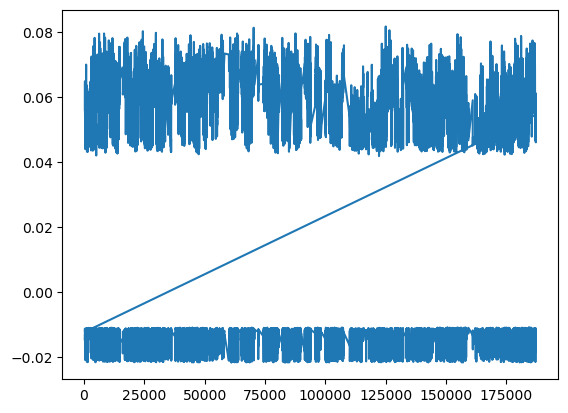

In [30]:
combined_data['combined_fee'].plot()

Optimized k for buying fees : 1.5679252188817048
Optimized k for selling fees: 0.12719206372762112


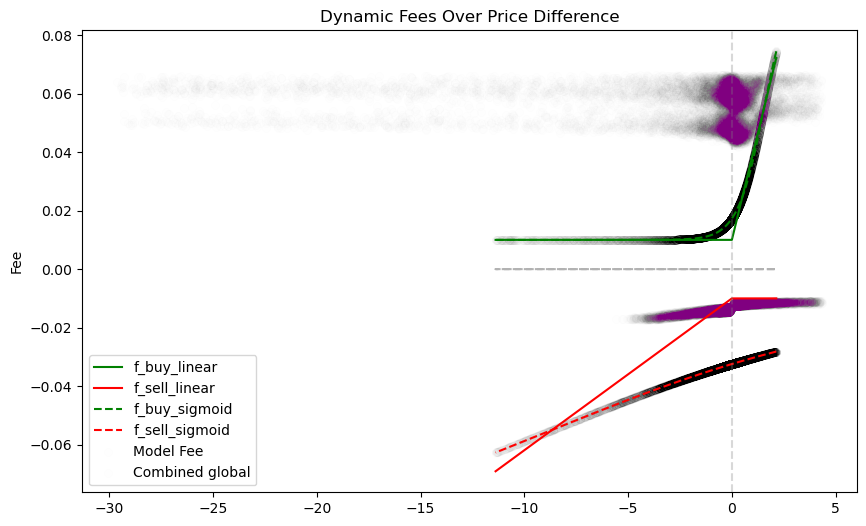

In [35]:
import matplotlib.pyplot as plt

feat = 'arb_pnl' # 'arb_pnl'
f_min  = 0.01
f_max  = 0.1
low_q  = 0.05
high_q = 0.95


scale_min = data_filtered[feat].quantile(high_q)
scale_max = data_filtered[feat].quantile(low_q)
delta_p = pd.DataFrame({'delta_p': np.linspace(scale_min, scale_max, 1000)})

## !! the price difference is stationnary because we cans stipulate the the dex and cex price are stationnary wich makes total sense 
# cause they are the same asset and arrbitragers always move to remove the differnce
# Then we dont really need to care of using the zscore also because we will redo a different calibration for a different pair 
# (so we dont need to normalize the time series of the difference)


# Segment the data based on 'amount1'
buy_subset = data_filtered[data_filtered['amount1'] < 0].copy()
sell_subset = data_filtered[data_filtered['amount1'] > 0].copy()

if len(sell_subset[sell_subset[feat]<0])>0:
    sell_max_fee_q = sell_subset[sell_subset[feat]<0][feat].quantile(low_q)
    sell_min_fee_q = sell_subset[sell_subset[feat]<0][feat].quantile(high_q)
else :
    sell_max_fee_q = sell_subset[sell_subset[feat]>0][feat].quantile(low_q)
    sell_min_fee_q = sell_subset[sell_subset[feat]>0][feat].quantile(high_q)
    
if len(buy_subset[buy_subset[feat]>0])>0:
    buy_max_fee_q  = buy_subset[buy_subset[feat]>0][feat].quantile(low_q)
    buy_min_fee_q  = buy_subset[buy_subset[feat]>0][feat].quantile(high_q)
else:
    buy_max_fee_q  = buy_subset[buy_subset[feat]<0][feat].quantile(low_q)
    buy_min_fee_q  = buy_subset[buy_subset[feat]<0][feat].quantile(high_q)

w_buy  = np.abs((f_max-f_min)/buy_min_fee_q)
w_sell = np.abs((f_max-f_min)/sell_max_fee_q)

x0_sell = np.abs(sell_max_fee_q/2)
x0_buy = np.abs(buy_min_fee_q/2)

delta_ps = np.linspace(scale_min, scale_max, 1000)
result_buy  = minimize(cost_function_buy,  1, args=(delta_ps, f_min, f_max, w_buy,  x0_buy))
result_sell = minimize(cost_function_sell, 1, args=(delta_ps, f_min, f_max, w_sell, x0_sell))

k_buy  = result_buy.x[0]
k_sell = result_sell.x[0]

print(f"Optimized k for buying fees : {k_buy}")
print(f"Optimized k for selling fees: {k_sell}")

# Apply the fees
buy_subset['model_fee'] = buy_subset[feat].apply(lambda x: adjusted_sigmoid(x, f_min, f_max, k_buy, x0_buy))
sell_subset['model_fee'] = -sell_subset[feat].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k_sell, x0_sell))

fus_data = pd.concat([buy_subset, sell_subset])

# plot the fees and the model fee
plt.figure(figsize=(10, 6))

plt.plot(delta_p['delta_p'],  delta_p['delta_p'].apply(lambda x: min(f_max, f_min + w_buy * max(0, x))),  label='f_buy_linear', color='green')
plt.plot(delta_p['delta_p'], -delta_p['delta_p'].apply(lambda x: min(f_max, f_min - w_sell * min(0, x))), label='f_sell_linear', color='red')
plt.plot(delta_p['delta_p'],  delta_p['delta_p'].apply(lambda x: adjusted_sigmoid(x,  f_min, f_max, k_buy,  x0_buy)),  label='f_buy_sigmoid',  linestyle='--', color='green')
plt.plot(delta_p['delta_p'], -delta_p['delta_p'].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k_sell, x0_sell)), label='f_sell_sigmoid', linestyle='--', color='red')

filtered_plot = (fus_data[feat] >= fus_data[feat].quantile(low_q)) & (fus_data[feat] <= fus_data[feat].quantile(high_q))
plt.scatter(fus_data[filtered_plot][feat], fus_data[filtered_plot]['model_fee'], alpha=0.005, color='black', label='Model Fee')

comb_plot = (combined_data[feat] >= combined_data[feat].quantile(low_q)) & (combined_data[feat] <= combined_data[feat].quantile(high_q))
plt.scatter(combined_data[comb_plot][feat], combined_data[comb_plot]['combined_fee'], alpha=0.005, color='purple', label='Combined global')

plt.plot(fus_data[filtered_plot][feat], [0]*len(fus_data[filtered_plot]), linestyle='--', alpha=0.3, color='black')
plt.axvline(0, color='gray', linestyle='--', alpha=0.3) 

plt.ylabel('Fee')
plt.legend()
plt.title('Dynamic Fees Over Price Difference')
plt.show()

In [ ]:
combined_data['combined_fee']